#Mount Google Drive

This will allow the Colab machine to access Google Drive folders by mounting the drive on the machine. You will be asked to copy and paste an authentication code.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Change directory to allow imports


In [2]:
import os
os.chdir("/content/gdrive/My Drive/CMPT 419 720 Project/")
!ls

'=2.0.1'
 BoxDist24_GT
 BoxDist24_TrackRCNN_Training
 BoxDist31_GT
 BoxDist31_TrackRCNN_Training
 cmpt419_mono_dept_esitmation_poster_v5.pdf
'CMPT419 Project Report.gdoc'
 FairMOT
 FairMOT.ipynb
 MDE_Experiments
'Milestone Report 1.gdoc'
'Milestone Report 2.gdoc'
 MonoDepthEstimation_v0.1
 output
 poster.gdoc
 References
 sceneflow
'synthetic data'
 testing
 trackr-cnn
 TrackRCNN
 TrackR-CNN
 trackr-cnn-v2
'TrackR-CNN x BoxDist24'
'TrackR-CNN x BoxDist31'
'TrackR-CNN x BoxDist31 Video Outs'
 training
'Weekly Briefings'


##Import Libraries

In [3]:
# import some common libraries
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch

##Set Directory

In [4]:
BASE_DIR = '/content/gdrive/My Drive/CMPT 419 720 Project/'
TRAINING_DIR = os.path.join(BASE_DIR, 'training')
OUTPUT_DIR = '{}/output'.format(BASE_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

#Experiments

##Bypass object identification/segmentation/tracking Apr6

Let's experiment with 1 frame look back, 

relative velocity known; segmentation & object tracking known & isolated

###Load in annotations with obj_id first

In [5]:
import pycocotools
import tensorflow as tf
from skimage import measure

class_ids = {
    'Car': 0,
    'Van': 1,
    'Truck': 2,
    'Pedestrian': 3,
    'Person': 4,
    'Cyclist': 5,
    'Tram': 6,
}
def obj_id_first_annotations(num_sets=21, poly_from_json=True):
  annotations = {}
  kitti_anno_dir = os.path.join(TRAINING_DIR, 'label_02')
  tracking_anno_dir = os.path.join(TRAINING_DIR, 'instances_txt')
  tf_anno_dir = os.path.join(TRAINING_DIR, 'instances')
  gps_anno_dir = os.path.join(TRAINING_DIR, 'oxts')
  file_name_template = '0000'
  for s in range(num_sets):
    set_name = file_name_template + str(s)
    set_name = set_name[len(set_name)-4:len(set_name)]
    kitti_anno_file = os.path.join(kitti_anno_dir, set_name+'.txt')
    tracking_anno_file = os.path.join(tracking_anno_dir, set_name+'.txt')
    gps_anno_file = os.path.join(gps_anno_dir, set_name+'.txt')
    records = {}

#Load GPS Annotations
    gps_anno = open(gps_anno_file, 'r')
    gps_lines = gps_anno.readlines()
    gps = {}
    for frame, line in enumerate(gps_lines):
      e = line.split(' ')
      v = [float(e[8]), float(e[9]), float(e[10])]
      a = [float(e[11]), float(e[12]), float(e[13])]
      gps[frame] = {
          'v': v,
          'a': a,
      }
    
    tracking_anno = open(tracking_anno_file, 'r')
    tracking_lines = tracking_anno.readlines()
    line = tracking_lines[0]
    e = line.split(' ')
    frame = int(e[0])
    height = int(e[3])
    width = int(e[4])

#Load Kitti Annotations
    kitti_anno = open(kitti_anno_file, 'r')
    kitti_lines = kitti_anno.readlines()
    for line in kitti_lines:
      e = line.split(' ')
      class_name = e[2]
      trunc = float(e[3])
      if class_name == 'DontCare' or class_name == 'Misc' or trunc > 0.0: #data exclusion
        continue
      frame = int(e[0])
      obj_id = int(e[1])
      if obj_id not in records.keys():
        records[obj_id] = {}
      if frame not in records[obj_id].keys():
        records[obj_id][frame] = {}
      records[obj_id]['class_name'] = class_name
      records[obj_id][frame] = {
          'img_id': set_name+str(frame),
          'class_name': class_name,
          'class_id': class_ids[class_name],
          'alpha': float(e[5]),
          'bbox': [float(e[6]), float(e[7]), float(e[8]), float(e[9])],
          'xyz': [float(e[13]), float(e[14]), float(e[15])],
          'wlht': [float(e[10]), float(e[11]), float(e[12]), float(e[16])],
          'v': gps[frame]['v'],
          'a': gps[frame]['a'],
          'height': height,
          'width': width,
      }

#Load Segmentation
    if poly_from_json:
      with open(TRAINING_DIR+'/seg_poly/'+set_name+'.json', 'r') as anno_json:
        imgs_anns = json.load(anno_json)
        for ann in imgs_anns:
          frame = ann['frame']
          obj_id = ann['obj_id']
          if obj_id not in records.keys() or frame not in records[obj_id].keys():
            continue
          records[obj_id][frame]['height'] = ann['height']
          records[obj_id][frame]['width'] = ann['width']
          records[obj_id][frame]['poly'] = ann['poly']
      anno_json.close()

    annotations[set_name] = records
  return annotations

In [6]:
obj_first_annotations = obj_id_first_annotations()

###Cherry Pick Datasets

Requirements: has to have more than 2 or more frames

In [7]:
def cherry_pick_data(annotations, lookback=1, class_targets=None, class_excludes=None):
  cherrypicked = {}
  for scene in annotations.keys():
    cherrypicked[scene] = {}
    for obj_id in annotations[scene].keys():
      frames = annotations[scene][obj_id].keys()
      class_name = annotations[scene][obj_id]['class_name']
      if len(frames)-1 < lookback+1 or (class_targets != None and class_name not in class_targets) or (class_excludes != None and class_name in class_excludes):
        continue
      cherrypicked[scene][obj_id] = annotations[scene][obj_id]
  return cherrypicked

###Construct pairwise annotations

Pair Frame 1 with Frame 2

Camera records at 10 frames per second: 0.1s between each frame.

Velocity in the direction toward the object of interest is therefore (dist2 - dist1)/0.1

NOTE: this is reducing the problem to the object being stationary

In [8]:
import math
import numpy as np

def v2d(vector):
  max_index = np.argmax(vector)
  dist = max_index + vector[max_index]
  return dist

def d2v(distance):
  v = [0.0]*1000
  for d in range(int(distance)):
    continue
  v[int(distance)] = 1.0
  return v

def dist(xyz):
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    return math.sqrt(x**2+y**2+z**2)

##predict displacement with forward euler
def dynamic_disp(v1, v2, a1, a2, t=0.1, h=0.001):
  ad = (a2-a1)/t
  d = 0
  v = v1
  a = a1
  for t in range(int(t/h)):
    a = a + h*ad
    v = v + h*a
    d += v*h + 0.5*a*h**2
  return d

def pairwise_bbox_agnostic(annotations):
  pair_wise_anno = []
  for scene in annotations.keys():
    for obj_id in annotations[scene].keys():
      frames = list(annotations[scene][obj_id].keys())
      frames.remove('class_name')
      frames.sort()
      for f in range(len(frames)-1):
        frame1 = annotations[scene][obj_id][frames[f]]
        frame2 = annotations[scene][obj_id][frames[f+1]]
        height = frame1['height']
        width = frame1['width']
        img_center = [width/2, height/2]
        bbox1 = [frame1['bbox'][0]/width, frame1['bbox'][1]/height, frame1['bbox'][2]/width, frame1['bbox'][3]/height]
        bbox2 = [frame2['bbox'][0]/width, frame2['bbox'][1]/height, frame2['bbox'][2]/width, frame2['bbox'][3]/height]
        xd = -dynamic_disp(frame1['v'][1], frame2['v'][1], frame1['a'][1], frame2['a'][1])
        yd = -dynamic_disp(frame1['v'][2], frame2['v'][2], frame1['a'][2], frame2['a'][2])
        zd = dynamic_disp(frame1['v'][0], frame2['v'][0], frame1['a'][0], frame2['a'][0])
        disp = [xd, yd, zd]
        dist2 = dist(frame2['xyz'])
        bbox1 = [frame1['bbox'][0]/width, frame1['bbox'][1]/height, frame1['bbox'][2]/width, frame1['bbox'][3]/height]
        bbox2 = [frame2['bbox'][0]/width, frame2['bbox'][1]/height, frame2['bbox'][2]/width, frame2['bbox'][3]/height]
        w1 = bbox1[2] - bbox1[0]
        w2 = bbox2[2] - bbox2[0]
        h1 = bbox1[3] - bbox1[1]
        h2 = bbox2[3] - bbox2[1]
        a1 = w1*h1
        a2 = w2*h2
        c1 = [(frame1['bbox'][0]+(w1/2)-img_center[0])/(width/2), (frame1['bbox'][1]+(h1/2)-img_center[1])/(height/2)]
        c2 = [(frame2['bbox'][0]+(w2/2)-img_center[0])/(width/2), (frame2['bbox'][1]+(h2/2)-img_center[1])/(height/2)]
        pair = {
            'input': np.array(bbox1 + bbox2 + disp + [w1, w2, h1, h2, a1, a2] + c1 + c2 + [w2/w1, h2/h1, a2/a1]).astype(np.float32),
            #'input': np.array(id_vec + bbox1 + bbox2 + disp + [w1, w2, h1, h2, a1, a2] + c1 + c2 + [w2/w1, h2/h1, a2/a1]).astype(np.float32),
            'output': np.array(frame2['xyz']).astype(np.float32),
        }
        pair_wise_anno.append(pair)
  return pair_wise_anno


###BBOX

####Load & Seperate Dataset

#####Multi-Class train & test

In [11]:
import random
random.seed()

anno = cherry_pick_data(obj_first_annotations)
dataset = pairwise_bbox_agnostic(anno)
# 50% training, 10% validation, 40% testing
train_input = []
train_output = []
valid_input = []
valid_output = []
test_input = []
test_output = []
for d in dataset:
  k = random.uniform(0, 1)
  if k < 0.5:
    continue
  r = random.uniform(0, 1)
  if r < 0.5:
    train_input.append(torch.from_numpy(d['input']))
    train_output.append(torch.from_numpy(d['output']))
  elif r < 0.6:
    valid_input.append(torch.from_numpy(d['input']))
    valid_output.append(torch.from_numpy(d['output']))
  else:
    test_input.append(torch.from_numpy(d['input']))
    test_output.append(torch.from_numpy(d['output']))

print("training: {} entries".format(len(train_input)))
print("validation: {} entries".format(len(valid_input)))
print("testing: {} entries".format(len(test_input)))

training: 10362 entries
validation: 2093 entries
testing: 8266 entries


#####'Sub-One' Class train, 'One' class test

In [ ]:
import random
random.seed()

excluded = ['Car']
anno = cherry_pick_data(obj_first_annotations, class_excludes=excluded)
train_dataset = pairwise_bbox_agnostic(anno)
non_anno = cherry_pick_data(obj_first_annotations, class_targets=excluded)
test_dataset = pairwise_bbox_agnostic(non_anno)
# 50% training, 10% validation, 40% testing
train_input = []
train_output = []
valid_input = []
valid_output = []
test_input = []
test_output = []
for d in train_dataset:
  r = random.uniform(0, 1)
  k = random.uniform(0, 1)
  if k < 0.5:
    continue
  if r < 0.9:
    train_input.append(torch.from_numpy(d['input']))
    train_output.append(torch.from_numpy(d['output']))
  else:
    valid_input.append(torch.from_numpy(d['input']))
    valid_output.append(torch.from_numpy(d['output']))

for d in test_dataset:
  k = random.uniform(0, 1)
  if k < 0.5:
    continue
  test_input.append(torch.from_numpy(d['input']))
  test_output.append(torch.from_numpy(d['output']))

print("training: {} entries".format(len(train_input)))
print("validation: {} entries".format(len(valid_input)))
print("testing: {} entries".format(len(test_input)))

training: 8033 entries
validation: 909 entries
testing: 11723 entries


####Network

Configs

In [9]:
n_epochs = 30
learning_rate = 0.001
batch_size = 64

Network Definition

In [10]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class BBoxDistNet_Agnostic(nn.Module):
  def __init__(self):
    super(BBoxDistNet_Agnostic, self).__init__()

    self.fc_net = nn.Sequential(
      nn.Linear(24, 18),
      nn.LayerNorm(18),
      nn.LeakyReLU(0.01, inplace=True),
      nn.Linear(18, 18),
      nn.LayerNorm(18),
      nn.LeakyReLU(0.01, inplace=True),
      nn.Linear(18, 3),
    )
  def forward(self, x):
    x = self.fc_net(x)
    return x

net = BBoxDistNet_Agnostic().cuda()

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0)
criterion = nn.L1Loss()

Training

In [ ]:
train_losses = []
valid_losses = []

[1] training_loss: 3.081
validation_loss: 3.495
[2] training_loss: 1.426
validation_loss: 6.204
[3] training_loss: 1.268
validation_loss: 2.714
[4] training_loss: 1.196
validation_loss: 2.471
[5] training_loss: 1.161
validation_loss: 2.478
[6] training_loss: 1.120
validation_loss: 2.275
[7] training_loss: 1.084
validation_loss: 2.107
[8] training_loss: 1.051
validation_loss: 2.101
[9] training_loss: 1.047
validation_loss: 2.255
[10] training_loss: 1.021
validation_loss: 2.201
[11] training_loss: 0.998
validation_loss: 1.952
[12] training_loss: 0.983
validation_loss: 1.987
[13] training_loss: 0.952
validation_loss: 1.847
[14] training_loss: 0.938
validation_loss: 1.836
[15] training_loss: 0.933
validation_loss: 1.750
[16] training_loss: 0.919
validation_loss: 2.003
[17] training_loss: 0.908
validation_loss: 1.563
[18] training_loss: 0.892
validation_loss: 1.568
[19] training_loss: 0.896
validation_loss: 1.542
[20] training_loss: 0.884
validation_loss: 1.440
[21] training_loss: 0.874
val

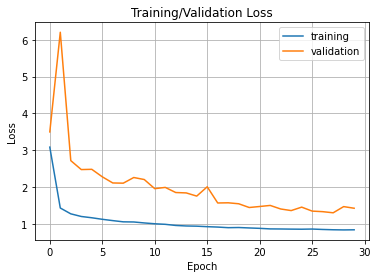

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

train_losses = []
valid_losses = []
for epoch in range(n_epochs):
  net.train()
  running_loss = 0
  for i in range(len(train_input)):
    input = train_input[i].cuda()
    output = net(input)
    target = train_output[i].cuda()
    #target.unsqueeze(0)
    optimizer.zero_grad()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    
  running_loss/=len(train_input)
  train_losses.append(running_loss)
  print('[%d] training_loss: %.3f' %(epoch + 1, running_loss))

  #validation
  net.eval()
  with torch.no_grad():
    valid_loss = 0
    for i in range(len(valid_input)):
      input = valid_input[i].cuda()
      target = valid_output[i].cuda()
      output = net(input)
      loss = criterion(output, target)
      valid_loss += loss.item()

    valid_loss /= len(valid_input)
    valid_losses.append(valid_loss)
    print('validation_loss: %.3f' %(valid_loss))
    if valid_loss < 0.75:
      break

epochs = [x for x in range(n_epochs)]
fig, ax = plt.subplots()
ax.plot(epochs, np.array(train_losses), label='training')
ax.plot(epochs, np.array(valid_losses), label='validation')
ax.set(xlabel='Epoch', ylabel='Loss',
       title='Training/Validation Loss')
ax.grid()
ax.legend()
plt.show()

In [ ]:
epochs = [x for x in range(len(valid_losses))]
fig, ax = plt.subplots()
ax.plot(epochs, np.array(train_losses), label='training')
ax.plot(epochs, np.array(valid_losses), label='validation')
ax.set(xlabel='Epoch', ylabel='Loss',
       title='Training/Validation Loss')
ax.grid()
ax.legend()
plt.show()

Testing

In [12]:
net = torch.load(os.path.join(OUTPUT_DIR, 'bbox24_1240_2783_100_multi.pt'))

In [13]:
mean_error = 0
mean_dist = 0
abs_errors = []
rel_errors = []
net.eval()
loss = 0
with torch.no_grad():
  for i in range(len(test_input)):
    input = test_input[i].cuda()
    target = test_output[i].cuda()
    mean_dist += dist(target)
    output = net(input)
    abs_errors.append(abs((dist(target)-dist(output))))
    rel_errors.append(abs((dist(target)-dist(output))/dist(target)))
    mean_error += math.sqrt((dist(target)-dist(output))**2)
    loss += criterion(output, target)
print('loss: %.3f' %(loss/len(test_input)))
mean_error /= len(test_input)
print('mean test absolute error: %.3f' %(np.mean(abs_errors)))
mean_dist /= len(test_input)
print('mean test relative error: %.3f' %(np.mean(rel_errors)))
print('median test absolute error: %.3f' %(np.median(np.sort(abs_errors))))
print('median test relative error: %.3f' %(np.median(np.sort(rel_errors))))

loss: 1.251
mean test absolute error: 2.809
mean test relative error: 0.100
median test absolute error: 1.401
median test relative error: 0.070


In [ ]:
torch.save(net, os.path.join(OUTPUT_DIR, 'bbox24_1240_2783_100_multi_30.pt'))

###Bit Mask (Sucks)

####Flatten Inputs (deprecated)

In [ ]:
#import torch.nn as nn
#from PIL import Image
#
#def flatten_bitmask(data):
#  fname1 = data['filename1']
#  fname2 = data['filename2']
#  disp = np.array(data['disp']).astype(np.float32)
#  image1 = np.array(Image.open(fname1)).astype(np.float32) / 255
#  image2 = np.array(Image.open(fname2)).astype(np.float32) / 255
#  flat1 = image1.flatten()
#  flat2 = image1.flatten()
#  input = np.append(np.append(flat1, flat2), disp)
#  tensor = torch.from_numpy(input)
#  return tensor

####Load & Seperate Dataset

#####Mono-Class train & test

In [ ]:
import random
random.seed()

targets = ['Car']
anno = cherry_pick_data(obj_first_annotations,class_targets=targets)
dataset = pairwise_bitmask(anno)
# 50% training, 10% validation, 40% testing
train = []
valid = []
test = []
for d in dataset:
  k = random.uniform(0, 1)
  if k < 0.9:
    continue
  r = random.uniform(0, 1)
  if r < 0.5:
    train.append(d)
  elif r < 0.6:
    valid.append(d)
  else:
    test.append(d)

print("training: {} entries".format(len(train)))
print("validation: {} entries".format(len(valid)))
print("testing: {} entries".format(len(test)))

training: 1157 entries
validation: 260 entries
testing: 981 entries


#####Multi-Class train & test

In [ ]:
import random
random.seed()

anno = cherry_pick_data(obj_first_annotations)
dataset = pairwise_bitmask(anno)
# 50% training, 10% validation, 40% testing
train = []
valid = []
test = []
for d in dataset:
  r = random.uniform(0, 1)
  if r < 0.5:
    train.append(d)
  elif r < 0.6:
    valid.append(d)
  else:
    test.append(d)

print("training: {} entries".format(len(train)))
print("validation: {} entries".format(len(valid)))
print("testing: {} entries".format(len(test)))

training: 14655 entries
validation: 2838 entries
testing: 11547 entries


#####Mono-Class train, Mono-Other-Class test

In [ ]:
import random
random.seed()

car_anno = cherry_pick_data(obj_first_annotations,class_targets=['Car'])
ped_anno = cherry_pick_data(obj_first_annotations,class_targets=['Pedestrian'])
train_dataset = pairwise_bitmask(car_anno)
test_dataset = pairwise_bitmask(ped_anno)

train = []
valid = []
test = []
for d in train_dataset:
  k = random.uniform(0, 1)
  if k < 0.8:
    continue
  r = random.uniform(0, 1)
  if r < 0.9:
    train.append(d)
  else:
    valid.append(d)

for d in test_dataset:
  test.append(d)

print("training: {} entries".format(len(train)))
print("validation: {} entries".format(len(valid)))
print("testing: {} entries".format(len(test)))

training: 4242 entries
validation: 496 entries
testing: 5357 entries


#####Model Contamination

In [ ]:
import random
random.seed()

car_anno = cherry_pick_data(obj_first_annotations,class_targets=['Car', 'Pedestrian'])
ped_anno = cherry_pick_data(obj_first_annotations,class_targets=['Car'])
train_dataset = pairwise_bitmask(car_anno)
test_dataset = pairwise_bitmask(ped_anno)

train = []
valid = []
test = []
for d in train_dataset:
  k = random.uniform(0, 1)
  if k < 0.8:
    continue
  r = random.uniform(0, 1)
  if r < 0.9:
    train.append(d)
  else:
    valid.append(d)

for d in test_dataset:
  if k < 0.8:
    continue
  test.append(d)

print("training: {} entries".format(len(train)))
print("validation: {} entries".format(len(valid)))
print("testing: {} entries".format(len(test)))

training: 5191 entries
validation: 566 entries
testing: 0 entries


####Network

Configs

In [ ]:
n_epochs = 20

Network Definition

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class BitmaskDistNet2D(nn.Module): #VGG16
  def __init__(self):
    super(BitmaskDistNet2D, self).__init__()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
    self.conv15 = nn.Conv2d(64, 64, 3, padding=1)
    self.bnorm1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv25 = nn.Conv2d(128, 128, 3, padding=1)
    self.bnorm2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv35 = nn.Conv2d(256, 256, 3, padding=1)
    self.bnorm3 = nn.BatchNorm2d(256)
    self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
    self.conv45 = nn.Conv2d(512, 512, 3, padding=1)
    self.bnorm4 = nn.BatchNorm2d(512)

  def forward(self, x):
    x = F.relu(self.bnorm1(self.conv1(x)))
    x = F.relu(self.bnorm1(self.conv15(x)))
    x = self.pool(x)

    x = F.relu(self.bnorm2(self.conv2(x)))
    x = F.relu(self.bnorm2(self.conv25(x)))
    x = self.pool(x)

    x = F.relu(self.bnorm3(self.conv3(x)))
    x = F.relu(self.bnorm3(self.conv35(x)))
    x = F.relu(self.bnorm3(self.conv35(x)))
    x = self.pool(x)

    x = F.relu(self.bnorm4(self.conv4(x)))
    x = F.relu(self.bnorm4(self.conv45(x)))
    x = F.relu(self.bnorm4(self.conv45(x)))
    x = self.pool(x)
   
    x = F.relu(self.bnorm4(self.conv45(x)))
    x = F.relu(self.bnorm4(self.conv45(x)))
    x = F.relu(self.bnorm4(self.conv45(x)))
    x = self.pool(x)

    x = torch.flatten(x)

    return x

class BitmaskDistNet1D(nn.Module): #VGG16
  def __init__(self):
    super(BitmaskDistNet1D, self).__init__()
    self.fc_net = nn.Sequential(
      nn.Linear(50179, 4096),
      nn.LayerNorm(4096),
      nn.ReLU(inplace=True),
      nn.Linear(4096, 4096),
      nn.LayerNorm(4096),
      nn.ReLU(inplace=True),
      nn.Linear(4096, 1),
    )

  def forward(self, x):
    x = self.fc_net(x)
    return x

net2D1 = BitmaskDistNet2D().cuda()
net2D2 = BitmaskDistNet2D().cuda()
net1D = BitmaskDistNet1D().cuda()
optimizer2D1 = optim.Adam(net2D1.parameters())
optimizer2D2 = optim.Adam(net2D2.parameters())
optimizer1D = optim.Adam(net1D.parameters())
criterion = nn.MSELoss()

Training

#####Batch(sucks)

In [ ]:
###Batch Loader
def batch_loader(file_names):
  image = tf.io.read_file(file_names[0])
  batch_np = tf.image.decode_image(image, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224)
  i = 1
  while i < batch_size:
    image = tf.io.read_file(file_names[i])
    image_np = tf.image.decode_image(image, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224)
    batch_np = np.append(batch_np, image_np, axis=0)
    i += 1
  tensor = torch.from_numpy(batch_np)
  return tensor

In [ ]:
random.seed()
torch.cuda.empty_cache()
for epoch in range(n_epochs):
  running_loss = 0
  random.shuffle(train)
  b = 0
  while b+batch_size < len(train):
    input_f1 = []
    input_f2 = []
    input_ds = []
    targets = []
    for i in range(batch_size):
      element = train[i+b]
      input_f1.append(element['input']['filename1'])
      input_f2.append(element['input']['filename2'])
      input_ds.append(element['input']['disp'])
      targets.append(element['output'])
    input1 = Variable(batch_loader(input_f1).cuda())
    input2 = Variable(batch_loader(input_f2).cuda())
    disps = np.array(input_ds, dtype=np.float32)
    targets = Variable(torch.from_numpy(np.array(targets)).cuda())
    
    optimizer2D1.zero_grad()
    optimizer2D2.zero_grad()
    optimizer1D.zero_grad()
    inter1 = net2D1(input1)
    inter2 = net2D2(input2)
    inter1 = inter1.cpu().numpy()
    inter2 = inter2.cpu().numpy()
    c_input = Variable(tf.concat([c_input,disps], 1))
    output = net1D(c_input)
    loss = criterion(output, target)
    loss.backward()
    optimizer1D.step()
    optimizer2D1.step()
    optimizer2D2.step()
    running_loss += loss.item()
    b+=batch_size
    
  running_loss/=len(train//batch_size)
  print('[%d] training_loss: %.3f' %(epoch + 1, running_loss))

  #validation
  error = 0
  for i in range(len(valid_input)):
    try:
      input = Variable(flatten_bitmask(valid_input[i]).cuda())
    except FileNotFoundError:
      continue
    target = valid_output[i].item()
    output = net(input).item()
    error += math.sqrt((target-output)**2)
  print('mean validation error: %.3f' %(error/len(valid_input)))

NameError: ignored

#####Indv

[1] training_loss: 150.157
validation_loss: 199.168
[2] training_loss: 96.166
validation_loss: 168.103
[3] training_loss: 80.239
validation_loss: 150.155
[4] training_loss: 71.749
validation_loss: 144.924
[5] training_loss: 64.976
validation_loss: 138.704
[6] training_loss: 57.665
validation_loss: 128.245
[7] training_loss: 51.815
validation_loss: 122.764
[8] training_loss: 45.082
validation_loss: 119.537
[9] training_loss: 41.897
validation_loss: 114.390
[10] training_loss: 37.096
validation_loss: 111.799
[11] training_loss: 32.921
validation_loss: 106.272
[12] training_loss: 31.269
validation_loss: 119.015
[13] training_loss: 26.220
validation_loss: 131.286
[14] training_loss: 24.800
validation_loss: 125.228
[15] training_loss: 25.017
validation_loss: 164.468
[16] training_loss: 25.591
validation_loss: 153.020
[17] training_loss: 23.336
validation_loss: 211.584
[18] training_loss: 23.433
validation_loss: 181.087
[19] training_loss: 33.835
validation_loss: 114.726
[20] training_loss: 

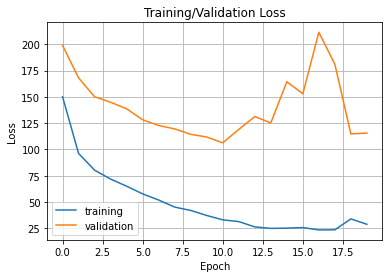

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

train_losses = []
valid_losses = []
for epoch in range(n_epochs):
  running_loss = 0
  net.train()
  for data in train:
    image1 = tf.io.read_file(data['input']['filename1'])
    tensor1 = torch.from_numpy(tf.image.decode_image(image1, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224))
    input1 = tensor1.cuda()
    image2 = tf.io.read_file(data['input']['filename2'])
    tensor2 = torch.from_numpy(tf.image.decode_image(image2, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224))
    input2 = tensor2.cuda()
    disp = np.array(data['input']['disp'], dtype=np.float32)
    target = torch.from_numpy(np.array(data['output']).astype(np.float32)).cuda()
    target = target.unsqueeze(0)
    
    optimizer2D1.zero_grad()
    optimizer2D2.zero_grad()
    optimizer1D.zero_grad()
    inter1 = net2D1(input1)
    inter2 = net2D2(input2)
    inter1 = inter1.cpu().detach().numpy()
    inter2 = inter2.cpu().detach().numpy()
    c_input = np.append(inter1, inter2)
    c_input = np.append(c_input, disp)
    c_input = c_input.astype(np.float32)
    c_input = torch.from_numpy(c_input).cuda()
    output = net1D(c_input)
    loss = criterion(output, target)
    loss.backward()
    optimizer1D.step()
    optimizer2D1.step()
    optimizer2D2.step()
    running_loss += loss.item()
    
  running_loss /= len(train)
  train_losses.append(running_loss)
  print('[%d] training_loss: %.3f' %(epoch + 1, running_loss))

  #validation
  valid_loss = 0
  net.eval()
  with torch.no_grad():
    for data in valid:
      image1 = tf.io.read_file(data['input']['filename1'])
      tensor1 = torch.from_numpy(tf.image.decode_image(image1, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224))
      input1 = tensor1.cuda()
      image2 = tf.io.read_file(data['input']['filename2'])
      tensor2 = torch.from_numpy(tf.image.decode_image(image2, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224))
      input2 = tensor2.cuda()
      disp = np.array(data['input']['disp'], dtype=np.float32)
      target = Variable(torch.from_numpy(np.array(data['output']).astype(np.float32)).cuda())
      target = target.unsqueeze(0)

      inter1 = net2D1(input1)
      inter2 = net2D2(input2)
      inter1 = inter1.cpu().detach().numpy()
      inter2 = inter2.cpu().detach().numpy()
      c_input = np.append(inter1, inter2)
      c_input = np.append(c_input, disp)
      c_input = c_input.astype(np.float32)
      c_input = torch.from_numpy(c_input).cuda()
      output = net1D(c_input)
      loss = criterion(output, target)
      valid_loss += loss.item()
    valid_loss /= len(valid)
    valid_losses.append(valid_loss)
    print('validation_loss: %.3f' %(valid_loss))

epochs = [x for x in range(n_epochs)]
fig, ax = plt.subplots()
ax.plot(epochs, np.array(train_losses), label='training')
ax.plot(epochs, np.array(valid_losses), label='validation')
ax.set(xlabel='Epoch', ylabel='Loss',
       title='Training/Validation Loss')
ax.grid()
ax.legend()
plt.show()

Testing

In [ ]:
mean_error = 0
mean_dist = 0
net.eval()
with torch.no_grad():
  for data in test:
    image1 = tf.io.read_file(data['input']['filename1'])
    tensor1 = torch.from_numpy(tf.image.decode_image(image1, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224))
    input1 = tensor1.cuda()
    image2 = tf.io.read_file(data['input']['filename2'])
    tensor2 = torch.from_numpy(tf.image.decode_image(image2, dtype=tf.float32, channels=1).numpy().reshape(1, 1, 224, 224))
    input2 = tensor2.cuda()
    disp = np.array(data['input']['disp'], dtype=np.float32)
    target = data['output']

    inter1 = net2D1(input1)
    inter2 = net2D2(input2)
    inter1 = inter1.cpu().detach().numpy()
    inter2 = inter2.cpu().detach().numpy()
    c_input = np.append(inter1, inter2)
    c_input = np.append(c_input, disp)
    c_input = c_input.astype(np.float32)
    c_input = torch.from_numpy(c_input).cuda()
    output = net1D(c_input)

    mean_dist += target
    mean_error += math.sqrt((target-output)**2)

mean_error /= len(test)
print('mean test absolute error: %.3f' %(mean_error))
mean_dist /= len(test)
print('mean test relative error: %.3f' %(mean_error/mean_dist))

mean test absolute error: 7.012
mean test relative error: 0.227


###N-Frame Lookback (bbox)

In [ ]:
height = 376
width = 1241
def pairwise_bbox(annotations):
  pair_wise_anno = []
  for scene in annotations.keys():
    for obj_id in annotations[scene].keys():
      frames = list(annotations[scene][obj_id].keys())
      frames.remove('class_name')
      frames.sort()
      for f in range(len(frames)-1):
        frame1 = annotations[scene][obj_id][frames[f]]
        frame2 = annotations[scene][obj_id][frames[f+1]]      
        xd = -dynamic_disp(frame1['v'][1], frame2['v'][1], frame1['a'][1], frame2['a'][1])
        yd = -dynamic_disp(frame1['v'][2], frame2['v'][2], frame1['a'][2], frame2['a'][2])
        zd = dynamic_disp(frame1['v'][0], frame2['v'][0], frame1['a'][0], frame2['a'][0])
        disp = [xd, yd, zd]
        distance = dist(frame2['xyz'])
        w1 = frame1['bbox'][2] - frame1['bbox'][0]
        w2 = frame2['bbox'][2] - frame2['bbox'][0]
        h1 = frame1['bbox'][3] - frame1['bbox'][1]
        h2 = frame2['bbox'][3] - frame2['bbox'][1]
        input = {
                'bbox1': [frame1['bbox'][0]/width, frame1['bbox'][1]/height, frame1['bbox'][2]/width, frame1['bbox'][3]/height],
                'bbox2': [frame2['bbox'][0]/width, frame2['bbox'][1]/height, frame2['bbox'][2]/width, frame2['bbox'][3]/height],
                'disp': disp,
            }
        pair = {
            'input': np.array(input['bbox1'] + input['bbox2'] + input['disp'] + [w2/w1, h2/h1]).astype(np.float32),
            'output': np.array(distance).astype(np.float32),
        }
        pair_wise_anno.append(pair)
  return pair_wise_anno

In [ ]:
n_epochs = 25

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class BBoxDistNet(nn.Module):
  def __init__(self):
    super(BBoxDistNet, self).__init__()

    self.fc_net = nn.Sequential(
      nn.Linear(13, 16),
      nn.LayerNorm(16),
      nn.ReLU(inplace=True),
      nn.Linear(16, 32),
      nn.LayerNorm(32),
      nn.ReLU(inplace=True),
      nn.Linear(32, 64),
      nn.LayerNorm(64),
      nn.ReLU(inplace=True),
      nn.Linear(64, 32),
      nn.LayerNorm(32),
      nn.ReLU(inplace=True),
      nn.Linear(32, 1),
    )
  def forward(self, x):
    x = self.fc_net(x)
    return x

net = BBoxDistNet().cuda()

optimizer = optim.Adam(net.parameters())
criterion = nn.MSELoss()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

train_losses = []
valid_losses = []
for epoch in range(n_epochs):
  running_loss = 0
  for i in range(len(train_input)):
    input = Variable(train_input[i].cuda())
    target = Variable(train_output[i].cuda())
    optimizer.zero_grad()
    output = net(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    
  running_loss/=len(train_input)
  train_losses.append(running_loss)
  print('[%d] training_loss: %.3f' %(epoch + 1, running_loss))

  #validation
  valid_loss = 0
  for i in range(len(valid_input)):
    input = valid_input[i].cuda()
    target = valid_output[i].cuda()
    output = net(input)
    loss = criterion(output, target)
    valid_loss += loss.item()

  valid_loss /= len(valid_input)
  valid_losses.append(valid_loss)
  print('validation_loss: %.3f' %(valid_loss))

epochs = [x for x in range(n_epochs)]
fig, ax = plt.subplots()
ax.plot(epochs, np.array(train_losses), label='training')
ax.plot(epochs, np.array(valid_losses), label='validation')
ax.set(xlabel='Epoch', ylabel='Loss',
       title='Training/Validation Loss')
ax.grid()
ax.legend()
plt.show()

In [ ]:
mean_error = 0
mean_dist = 0
for i in range(len(test_input)):
  input = Variable(test_input[i].cuda())
  target = test_output[i].item()
  mean_dist += target
  output = net(input).item()
  mean_error += math.sqrt((target-output)**2)
mean_error /= len(test_input)
print('mean test absolute error: %.3f' %(mean_error))
mean_dist /= len(test_input)
print('mean test relative error: %.3f' %(mean_error/mean_dist))

#Demo Video

In [ ]:
import pycocotools
from skimage import measure

class_ids = {
    'Car': 0,
    'Van': 1,
    'Truck': 2,
    'Pedestrian': 3,
    'Person': 4,
    'Cyclist': 5,
    'Tram': 6,
}
def frame_first_set_annotations(set_name):
  kitti_anno_dir = os.path.join(TRAINING_DIR, 'label_02')
  tracking_anno_dir = os.path.join(TRAINING_DIR, 'instances_txt')
  tf_anno_dir = os.path.join(TRAINING_DIR, 'instances')
  gps_anno_dir = os.path.join(TRAINING_DIR, 'oxts')

  kitti_anno_file = os.path.join(kitti_anno_dir, set_name+'.txt')
  tracking_anno_file = os.path.join(tracking_anno_dir, set_name+'.txt')
  gps_anno_file = os.path.join(gps_anno_dir, set_name+'.txt')
  records = {}

  tracking_anno = open(tracking_anno_file, 'r')
  tracking_lines = tracking_anno.readlines()
  line = tracking_lines[0]
  e = line.split(' ')
  frame = int(e[0])
  height = int(e[3])
  width = int(e[4])

#Load Kitti Annotations
  kitti_anno = open(kitti_anno_file, 'r')
  kitti_lines = kitti_anno.readlines()
  for line in kitti_lines:
    e = line.split(' ')
    class_name = e[2]
    trunc = float(e[3])
    frame = int(e[0])
    if frame not in records.keys():
      records[frame] = {}
      records[frame]['objs'] = {}
    if class_name == 'DontCare' or class_name == 'Misc' or trunc > 0.0: #data exclusion
      continue
    obj_id = int(e[1])
    records[frame]['img_id'] = set_name+str(frame)
    records[frame]['objs'][obj_id] = {
        'class_name': class_name,
        'class_id': class_ids[class_name],
        'alpha': float(e[5]),
        'bbox': [float(e[6]), float(e[7]), float(e[8]), float(e[9])],
        'xyz': [float(e[13]), float(e[14]), float(e[15])],
        'wlht': [float(e[10]), float(e[11]), float(e[12]), float(e[16])],
        'height': height,
        'width': width,
    }

#Load GPS Annotations
  gps_anno = open(gps_anno_file, 'r')
  gps_lines = gps_anno.readlines()
  for frame, line in enumerate(gps_lines):
    e = line.split(' ')
    if frame not in records.keys():
      records[frame] = {}
    v = [float(e[8]), float(e[9]), float(e[10])]
    a = [float(e[11]), float(e[12]), float(e[13])]
    records[frame]['dynamics'] = {
        'v': v,
        'a': a,
    }

  return records

In [ ]:
set_names = ['0020']
for set_name in set_names:
  annotations = frame_first_set_annotations(set_name)
  make_videos(set_name)

In [ ]:
net = torch.load(os.path.join(OUTPUT_DIR, 'bbox_multi-multi_trunc_class_61.pt'))

In [ ]:
def make_videos(set_name):
  img_dir = os.path.join(os.path.join(TRAINING_DIR, 'image_02'), set_name)
  height = 376
  width = 1241
  img_center = [width/2, height/2]
  vid_writer = cv2.VideoWriter(filename=OUTPUT_DIR+"/dist_est_demo_multi_"+set_name+".avi",  #Provide a file to write the video to
  fourcc=cv2.VideoWriter_fourcc('p', 'n', 'g', ' '),            #Use whichever codec works for you...
  fps=10,                                        #How many frames do you want to display per second in your video?
  frameSize=(width, height))   

  #prev data
  data = {}

  net.eval()
  with torch.no_grad():
      for frame in annotations.keys():
        img_name = '000000'
        img_name = img_name[0:6-len(str(frame))] + str(frame)
        print(img_name)
        img = cv2.imread(os.path.join(img_dir, img_name+'.png'))
        print(img.shape)
        frame_anno = annotations[frame]
        if 'objs' not in frame_anno.keys():
          continue
        for obj_id in frame_anno['objs'].keys():
          obj_anno = frame_anno['objs'][obj_id]
          class_name = obj_anno['class_name']
          #maybe do exclusion
          #if class_name != 'Car':
          #  continue
          bbox = obj_anno['bbox'] #XYXY_ABS
          dynamics = frame_anno['dynamics']
          if obj_id not in data.keys():
            data[obj_id] = {}
          data[obj_id][frame] = {
              'bbox': bbox,
              'v': dynamics['v'],
              'a': dynamics['a'],
              'class_id': obj_anno['class_id'],
              'gt': dist(obj_anno['xyz'])
          }
          #continue due to no prev data
          if frame-1 not in data[obj_id].keys():
            continue
          #feed into model
          frame1 = data[obj_id][frame-1]
          frame2 = data[obj_id][frame]
          bbox1 = [frame1['bbox'][0]/width, frame1['bbox'][1]/height, frame1['bbox'][2]/width, frame1['bbox'][3]/height]
          bbox2 = [frame2['bbox'][0]/width, frame2['bbox'][1]/height, frame2['bbox'][2]/width, frame2['bbox'][3]/height]
          xd = -dynamic_disp(frame1['v'][1], frame2['v'][1], frame1['a'][1], frame2['a'][1])
          yd = -dynamic_disp(frame1['v'][2], frame2['v'][2], frame1['a'][2], frame2['a'][2])
          zd = dynamic_disp(frame1['v'][0], frame2['v'][0], frame1['a'][0], frame2['a'][0])
          disp = [xd, yd, zd]
          bbox1 = [frame1['bbox'][0]/width, frame1['bbox'][1]/height, frame1['bbox'][2]/width, frame1['bbox'][3]/height]
          bbox2 = [frame2['bbox'][0]/width, frame2['bbox'][1]/height, frame2['bbox'][2]/width, frame2['bbox'][3]/height]
          w1 = bbox1[2] - bbox1[0]
          w2 = bbox2[2] - bbox2[0]
          h1 = bbox1[3] - bbox1[1]
          h2 = bbox2[3] - bbox2[1]
          a1 = w1*h1
          a2 = w2*h2
          c1 = [(frame1['bbox'][0]+(w1/2)-img_center[0])/(width/2), (frame1['bbox'][1]+(h1/2)-img_center[1])/(height/2)]
          c2 = [(frame2['bbox'][0]+(w2/2)-img_center[0])/(width/2), (frame2['bbox'][1]+(h2/2)-img_center[1])/(height/2)]
          #class_id = frame1['class_id']
          #id_vec = [0, 0, 0, 0, 0, 0, 0]
          #id_vec[class_id] = 1
          input = np.array(bbox1 + bbox2 + disp + [w1, w2, h1, h2, a1, a2] + c1 + c2 + [w2/w1, h2/h1, a2/a1]).astype(np.float32)
          input = torch.from_numpy(input).cuda()
          dist_estimate = dist(net(input))
          #draw boxes
          label = '%.2f | %.2f' % (dist_estimate, frame2['gt'])
          x1 = int(bbox[0])
          x2 = int(bbox[2])
          y1 = int(bbox[1])
          y2 = int(bbox[3])
          cv2.rectangle(img,(x1,y1),(x2,y2),(0,200,0),1)
          labelSize=cv2.getTextSize(label,cv2.FONT_HERSHEY_SIMPLEX,0.5,2)
          _x1 = x1
          _y1 = y1#+int(labelSize[0][1]/2)
          _x2 = _x1+labelSize[0][0]
          _y2 = y1-int(labelSize[0][1])
          cv2.rectangle(img,(_x1,_y1),(_x2,_y2),(0,200,0),cv2.FILLED)
          cv2.putText(img,label,(x1,y1),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,255),1)
          #write to video
        vid_writer.write(img)

  vid_writer.release()

In [ ]:
vid_writer.release()

NameError: ignored

In [ ]:
!ls output/

bbox_car_107_trunc.pt		    bbox_multi-multi_trunc_class_85.pt
bbox_multi_116_trunc.pt		    bbox_sans_car_137.pt
bbox_multi_multi_136.pt		    dist_est_demo_multi_0000.avi
bbox_multi-multi_trunc_class_61.pt  dist_est_demo_multi_0001.avi
